# Modules

In [1]:
import numpy as np
import math
import scipy
import py3nj
from sympy.physics.wigner import wigner_3j
from sympy.physics.wigner import wigner_6j
from sympy.physics.wigner import wigner_9j
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
def neg_1_pow(x):
    return 1 - 2 * (x % 2)


def delta(x1, x2):
    if x1 == x2:
        return True
    else:
        return False
    
def inverse_cm_to_MHz(E_in_inverse_cm):
    return 29979.2458 * E_in_inverse_cm

def val_ct_add_ang_mom(L1, L2, doubled):
    # returns the number of values in the array add_ang_mom
    if doubled:
        incr = 2
    else:
        incr = 1
    
    Lt_max = L1 + L2
    Lt_min = abs(L1-L2)
    
    return int((Lt_max - Lt_min + incr) / incr)

def add_ang_mom(L1, L2, doubled):
    # given the values of two different angular momenta, returns an array 
    # of the possible values of their sum L1+L2 = Lt
    #
    # doubled specifies whether the values of L1 and L2 are doubled upon input
    
    if doubled:
        incr = 2
    else:
        incr = 1
    
    Lt_max = L1 + L2
    Lt_min = abs(L1-L2)
    
    if Lt_max == Lt_min:
        return np.array([Lt_max])
    else:
        Lt = np.zeros(int((Lt_max - Lt_min + incr)/ incr))
        temp = Lt_min
        i = 0
        while temp <= Lt_max:
            Lt[i] = temp
            temp = temp + incr
            i += 1
        return Lt

In [3]:
class Interaction:
    def __init__(self, const, functn):
        # const is some constant associated with the interaction energy
        # funct is a function which evaluates the matrix element <state1|interaction|state2>
        self.const = const
        self.functn = functn
        
    def eval_interaction(self, state1, state2):
        return self.const * self.functn(state1, state2)
        
class State:
    def __init__(self, N, S, J, I, F, mF, doubled):
        # N is 2 times the rotational quantum number
        # S is 2 times the electron spin of the system
        # I is 2 times the total nuclear spin
        # F is 2 times the sum of I and J
        # mF is 2 times the projection of F onto the z axis
        # State class converts these inputs into physical values (halves each)
        
        if doubled:
            self.N = 0.5*N
            self.S = 0.5*S
            self.J = 0.5*J
            self.I = 0.5*I
            self.F = 0.5*F
            self.mF = 0.5*mF
        else:
            self.N = N
            self.S = S
            self.J = J
            self.I = I
            self.F = F
            self.mF = mF
        
    def __str__(self):
        # prints the physical values for each element within the state
        return "N:"+ str(self.N) + " S:" + str(self.S) + " J:" + str(self.J) + " I:" + str(self.I) + " F:" + str(self.F) + " mF:" + str(self.mF)
    
    def get_state_vector(self):
        return [self.N, self.S, self.J, self.I, self.F, self.mF]

In [4]:
add_ang_mom(1, 1, False)

array([0., 1., 2.])

In [5]:
class Molecule_fixed_S:
    
    def __init__(self, N, S, I1, I2):
        # N is an array holding the rotational quantum number
        # S is the electron spin of the system
        # I1 is the nuclear spin of atom one
        # I2 is the nuclear spin of atom two
        #
        # We double each input so that we can work with integer values
        self.N = np.multiply(N, 2)
        self.S = int(2*S)
        self.I1 = int(2*I1)
        self.I2 = int(2*I2)  
        self.states = []
    
        stupid = True
        for n in self.N:
            for j in add_ang_mom(n, self.S, True):
                for i in add_ang_mom(self.I1, self.I2, True):
                    if stupid:
                        print(i)
                    for f in add_ang_mom(i, j, True):
                        for mf in np.arange(-f,f+1,2):
                            self.states.append(State(n, self.S, j, i, f, mf, True))
                stupid = False

        #for state in self.states:
        #    print(state)
        
        self.dim = len(self.states)
        print("H has dim", self.dim)
        
        # array of interaction functions
        self.interactions = []
        self.changing_interaction = 0
        
        #Initialize static Hamiltonian, changing Hamiltonian, and total hamiltonian
        self.H_zero = np.zeros((self.dim,self.dim))
        self.H_prime = np.zeros((self.dim,self.dim))
        self.H = np.zeros((self.dim,self.dim))
        
        self.nonzero_indices = []
        
    def add_interaction(self, interaction):
        self.interactions.append(interaction)
        
    def update_changing_interaction(self, interaction):
        # change to add changing interaction
        self.changing_interaction = interaction
    
    def find_H_zero(self):
        if len(self.interactions) == 0:
            print("There are no interactions in the interaction array.")

        # Fill Hamiltonian matrix with term by term 
        for i in range(self.dim):
            for j in range(i,self.dim):
                term_zero = 0
                for interaction in self.interactions:
                    term_zero += interaction.eval_interaction(self.states[i], self.states[j])
                self.H_zero[i][j] = term_zero
                self.H_zero[j][i] = np.conjugate(term_zero)
        
        self.H = self.H_zero
        
        return self.H

    def update_H_prime(self):
        # !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
        # FIX THIS 
        # !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
        
        term_prime = 0
        
        if not self.nonzero_indices:
            for i in range(self.dim):
                for j in range(i,self.dim):
                    term_prime = self.changing_interaction.eval_interaction(self.states[i], self.states[j])
                    if term_prime != 0:
                        self.nonzero_indices.append((i,j))
                    self.H_prime[i][j] = term_prime
                    self.H_prime[j][i] = np.conjugate(term_prime)
        else:
            for elem in self.nonzero_indices:
                i,j = elem
                term_prime = self.changing_interaction.eval_interaction(self.states[i], self.states[j])
                self.H_prime[i][j] = term_prime
                self.H_prime[j][i] = np.conjugate(term_prime)
                
        self.H = np.add(self.H_zero, self.H_prime)
        
        return self.H

    def find_eigen_states(self):
        eigenstates = scipy.linalg.eig(self.H)
        
        return eigenstates[0], eigenstates[1]
    
    def get_H(self):
        return self.H
    
    def get_H_zero(self):
        return self.H_zero
    
    def get_H_prime(self):
        return self.H_prime

# Interaction Functions

In [ ]:
def itrcn_rot_1(state1, state2):
    N1, S1, J1, I1, F1, mF1 = state1.get_state_vector()
    N, S, J, I, F, mF = state2.get_state_vector()
    
    delta_part = delta(N1,N) and delta(J1,J) and delta(S1,S) and delta(I1,I) and delta(F1, F) and delta(mF1,mF)
    if not delta_part:
        return 0
    
    val = N * (N+1)
    #print("rot 1 ", val)
    return val

def itrcn_rot_2(state1, state2):
    N1, S1, J1, I1, F1, mF1 = state1.get_state_vector()
    N, S, J, I, F, mF = state2.get_state_vector()
    
    delta_part = delta(N1,N) and delta(J1,J) and delta(S1,S) and delta(I1,I) and delta(F1, F) and delta(mF1,mF)
    if not delta_part:
        return 0
    
    wigpart = 1
    val = -1 * delta_part * N * (N+1) * (N+1)
    #print("rot 2 ", val)
    return val

def itrcn_SR_1(state1, state2):
    N1, S1, J1, I1, F1, mF1 = state1.get_state_vector()
    N, S, J, I, F, mF = state2.get_state_vector()
    
    delta_part = delta(N1,N) and delta(J1,J) and delta(S1,S) and delta(I1,I) and delta(F1, F) and delta(mF1,mF)
    if not delta_part:
        return 0
    
    val = 0.5 * delta_part * (J * (J + 1) - N * (N+1) - S*(S+1))
    #print("SR_1 ", val)
    return val

def itrcn_SR_2(state1, state2):
    N1, S1, J1, I1, F1, mF1 = state1.get_state_vector()
    N, S, J, I, F, mF = state2.get_state_vector()
    
    delta_part = delta(N1,N) and delta(J1,J) and delta(S1,S) and delta(I1,I) and delta(F1, F) and delta(mF1,mF)
    if not delta_part:
        return 0
    
    val= 0.5 * delta_part * N * (N + 1) * (J * (J + 1) - N * (N+1) - S*(S+1))
    #print("SR_2 ", val)
    return val 

def itrcn_F(state1, state2):
    N1, S1, J1, I1, F1, mF1 = state1.get_state_vector()
    N, S, J, I, F, mF = state2.get_state_vector()
    
    delta_part = delta(N1,N) and delta(S1,S) and delta(I1,I) and delta(F1, F) and delta(mF1,mF)
    if not delta_part:
        return 0
    
    wig1 = wigner_6j(I, J1, F, J, I, 1) 
    if wig1 == 0:
        return 0
    wig2 = wigner_6j(S, J1, N, J, S, 1)
    if wig2 == 0:
        return 0
    
    other = neg_1_pow(F+I+J+J1+N+S+1) * np.sqrt(I * (I + 1) * (2*I + 1) * S * (S + 1) * (2*S +1) * (2*J1 + 1) * (2*J + 1))
    if other == 0:
        return 0
    
    val = wig1 * wig2 * other
    #print("itrcn_F ", val)
    return val

def itrcn_dip(state1, state2):
    N1, S1, J1, I1, F1, mF1 = state1.get_state_vector()
    N, S, J, I, F, mF = state2.get_state_vector()
    
    delta_part = delta(S1,S) and delta(I1,I) and delta(F1, F) and delta(mF1,mF)
    if not delta_part:
        return 0
    
    wig1 = wigner_6j(I, J1, F, J, I, 1) 
    if wig1 == 0:
        return 0
    wig2 = wigner_9j(N1, N, 2, S, S, 1, J1, J, 1) 
    if wig2 == 0:
        return 0
    wig3 = wigner_3j(N1, 2, N, 0, 0, 0)
    if wig3 == 0:
        return 0
    
    other = neg_1_pow(F+I+J+N1+1) * np.sqrt(30*I * (I + 1) * (2*I + 1) * S * (S + 1) * (2*S +1) * (2*J1 + 1) * (2*J + 1) * (2*N + 1) * (2*N1 + 1))
    if other == 0:
        return 0
    
    val = wig1 * wig2 * wig3 * other
    #print("dip ", val)
    return val


def itrcn_IN(state1, state2):
    N1, S1, J1, I1, F1, mF1 = state1.get_state_vector()
    N, S, J, I, F, mF = state2.get_state_vector()
    
    delta_part = delta(N1,N) and delta(S1,S) and delta(I1,I) and delta(F1, F) and delta(mF1,mF)
    if not delta_part:
        return 0
    
    wig1 = wigner_6j(J, 1, J1, I, F, I)
    if wig1 == 0:
        return 0
    wig2 = wigner_6j(N, 1, N, J1, S, J)
    if wig2 == 0:
        return 0
    
    other = neg_1_pow(F+I+J1+J+N+S+1) * np.sqrt(I * (I + 1) * (2*I + 1) * N * (N + 1) * (2*N + 1) * (2*J1 + 1) * (2*J + 1))
    if other == 0:
        return 0
    
    val = wig1 * wig2 * other
    #print("itrcn_IN ", val)
    return val

# need to adjust for each individual molecule, adjusting for I1 and I2
def itrcn_eqQ(state1, state2):
    N1, S1, J1, I1, F1, mF1 = state1.get_state_vector()
    N, S, J, I, F, mF = state2.get_state_vector()
    
    I_nuc1 = 1
    I_nuc2 = 1
    # LOOK INTO THIS
    
    delta_part = delta(S1,S) and delta(F1, F) and delta(mF1,mF)
    if not delta_part:
        return 0
    
    wig1 = wigner_6j(I1, 2, I, J, F, J1)
    if wig1 == 0:
        return 0
    wig2 = wigner_6j(I_nuc1, 2, I_nuc1, I, I_nuc1, I1) 
    if wig2 == 0:
        return 0
    wig3 = wigner_6j(N1, 2, N, J, S, J1)
    if wig3 == 0:
        return 0
    wig4 = wigner_3j(N1, 2, N, 0, 0, 0)
    if wig4 == 0:
        return 0
    wig5 = wigner_3j(I_nuc1, 2, I_nuc1, -I_nuc1, 0, I_nuc1)
    if wig5 == 0:
        return 0
    
    other = (neg_1_pow(I) + neg_1_pow(I1)) * neg_1_pow(F + I1 + 2*J + 2*I_nuc1 + S + 2*N1) * np.sqrt((2*I + 1)*(2*I1 + 1)*(2*J + 1)*(2*J1 + 1)*(2*N + 1)*(2*N1 + 1))
    if other == 0:
        return 0
    
    val = 0.25 * other * wig1 * wig2 * wig3 * wig4 / wig5
    #print("itrcn_eqQ", val)
    return val

def feed_B_field(B):
    def itrcn_Zem(state1, state2):
        N1, S1, J1, I1, F1, mF1 = state1.get_state_vector()
        N, S, J, I, F, mF = state2.get_state_vector()
        
        delta_part = delta(N1,N) and delta(S1, S) and delta(I1,I)
        if not delta_part:
            return 0
        
        wig1 = wigner_3j(F1, 1, F, -mF1, 0, mF) 
        if wig1 == 0:
            return 0
        wig2 = wigner_6j(F1, J1, I, J, F, 1) 
        if wig2 == 0:
            return 0
        wig3 = wigner_6j(J1, S, N, S, J, 1)
        if wig3 == 0:
            return 0
        
        other = neg_1_pow(2*J1 + N + S + F + I + F1 - mF1) * np.sqrt((2*F1 + 1)*(2*F + 1) * (2*J1 + 1) * (2*J + 1) * S * (S + 1) * (2*S + 1))
        if other == 0:
            return 0
        
        val = wig1 * wig2 * wig3 * other
        #print("itrcn_Zem", val)
        return B * val
    return itrcn_Zem

# Parameter Definitions

In [7]:
N2_plus = Molecule_fixed_S([0,1,2,3], 0.5, 1, 1)

B_e = inverse_cm_to_MHz(1.9223897)
D_e = inverse_cm_to_MHz(5.9758e-6)
gamma = 276.92253
gamma_n = -3.9790e-4
b_F = 100.6040
C_dip = 28.1946
C_I = 0.01132
eqQ = 0.7079

mu_b = 1.39962449171 #MHz/Gaus
g = 2.00233184

rotation_interaction_1 = Interaction(B_e, itrcn_rot_1)
N2_plus.add_interaction(rotation_interaction_1)

rotation_interaction_2 = Interaction(D_e, itrcn_rot_2)
N2_plus.add_interaction(rotation_interaction_2)

spin_rotation_interaction_1 = Interaction(gamma, itrcn_SR_1)
N2_plus.add_interaction(spin_rotation_interaction_1)

spin_rotation_interaction_2 = Interaction(gamma_n, itrcn_SR_2)
N2_plus.add_interaction(spin_rotation_interaction_2)

nuclear_spin_F = Interaction(b_F, itrcn_F)
N2_plus.add_interaction(nuclear_spin_F)

nuclear_dipole_interaction = Interaction(C_dip, itrcn_dip)
N2_plus.add_interaction(nuclear_dipole_interaction)

nuclear_spin_rotation_interaction = Interaction(C_I, itrcn_IN)
N2_plus.add_interaction(nuclear_spin_rotation_interaction)

nuclear_quadrupole_interaction = Interaction(eqQ, itrcn_eqQ)
N2_plus.add_interaction(nuclear_quadrupole_interaction)

0.0
2.0
4.0
H has dim 288


# Test Run for N2

In [8]:
from tqdm import tqdm

In [9]:
eigenvalues_vs_B = []
N2_plus.find_H_zero()
zeeman_interaction = Interaction(g*mu_b, feed_B_field(0))
    
# this is the only term which should be updated
N2_plus.update_changing_interaction(zeeman_interaction)
N2_plus.update_H_prime()
eigenvalues_vs_B.append(np.sort(np.real_if_close(N2_plus.find_eigen_states()[0]))[:16])

for B in tqdm(np.arange(1,100,1)):
    zeeman_interaction = Interaction(g*mu_b, feed_B_field(B))
    
    # this is the only term which should be updated
    N2_plus.update_changing_interaction(zeeman_interaction)
    N2_plus.update_H_prime()
    
    eigenvalues_vs_B.append(np.sort(np.real_if_close(N2_plus.find_eigen_states()[0]))[:20])


100%|██████████| 99/99 [00:51<00:00,  1.93it/s]


In [10]:
%matplotlib ipympl

In [11]:
plotting = [[val[i] for val in eigenvalues_vs_B] for i in np.array(range(len(eigenvalues_vs_B[0])))]

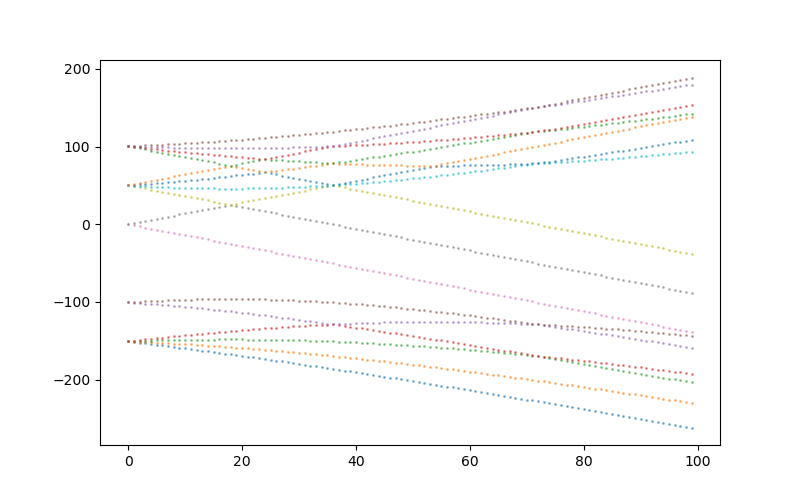

In [12]:
fig, ax = plt.subplots(figsize=(8, 5))
for list in plotting:
    ax.plot(list, 'o', alpha = 0.5,  markersize=1)

# Complexity

In [13]:
for i in range(100000):
    py3nj.wigner3j(2,2,4,-2,0,2) 

In [14]:
from sympy.physics.wigner import wigner_3j

In [15]:
for i in range(100000):
    wigner_3j(1,1,2,-1,0,1).evalf()

In [16]:
ct = 0
for elem in N2_plus.get_H_prime():
    for val in elem:
        if val != 0:
            ct = ct+1

In [17]:
print(N2_plus.dim*N2_plus.dim)
print(ct/N2_plus.dim*N2_plus.dim)


82944
1076.0


In [18]:
for i in range(100000):
    py3nj.wigner3j(0,0,0,0,0,0)

In [19]:
for i in range(100000):
    wigner_3j(0,0,0,0,0,0)